In [1]:
import sys
sys.path.append('..')
import warnings
warnings.filterwarnings('ignore')

In [2]:
import torch
import torch.nn.functional as F
import numpy as np
from torchvision.datasets import MNIST
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
from collections import OrderedDict
from torch.nn.parameter import Parameter
import matplotlib.pyplot as plt
from MogrifierLSTM import MogrifierLSTMCell
from utils.dataset import NCDFDatasets
from utils.evaluator import Evaluator
import adamod


In [3]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
device
if (torch.cuda.is_available()):
    torch.cuda.empty_cache()

In [4]:
import random as rd
seed = 1000
np.random.seed(seed)
rd.seed(seed)
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)
torch.backends.cudnn.deterministic=True

In [5]:
def init_seed(seed):
    np.random.seed(seed)
    
init_seed = init_seed(seed)

In [6]:
batch_size = 5
validation_split = 0.2
test_split = 0.2
dropout_rate = 0.2
hidden_size = 2500
mogrify_rounds = 5
prediction_window=5
param = {'encoder_layer_size': 3, 'decoder_layer_size': 3, 'kernel_size': 5, 'filter_size': 32}

In [7]:
import xarray as xr
data_path = '../data/dataset-chirps-1981-2019-seq5-ystep5.nc'
dataset = xr.open_dataset(data_path)
print(dataset)

<xarray.Dataset>
Dimensions:  (channel: 1, lat: 50, lon: 50, sample: 13960, time: 5)
Coordinates:
  * lat      (lat) int64 -39 -38 -37 -36 -35 -34 -33 -32 ... 3 4 5 6 7 8 9 10
  * lon      (lon) int64 -84 -83 -82 -81 -80 -79 -78 ... -40 -39 -38 -37 -36 -35
Dimensions without coordinates: channel, sample, time
Data variables:
    x        (sample, time, lat, lon, channel) float32 ...
    y        (sample, time, lat, lon, channel) float32 ...
Attributes:
    description:  The variables have preciptation values and are separable in...


In [8]:
#In these experiments y has dimensions [batch, channel, lat, lon] as opposed to [batch, channel, time, lat, lon] to
#avoid dimension conflict with conv kernels
data = NCDFDatasets(dataset, val_split = validation_split, test_split = test_split)
train_data = data.get_train()
val_data = data.get_val()
test_data = data.get_test()

In [9]:
print("-----Train-----")
print("X : ", train_data.x.shape)
print("Y : ", train_data.y.shape)
print("-----Val-----")
print("X : ", val_data.x.shape)
print("Y : ", val_data.y.shape)
print("-----Test-----")
print("X : ", test_data.x.shape)
print("Y : ", test_data.y.shape)

-----Train-----
X :  torch.Size([8376, 1, 5, 50, 50])
Y :  torch.Size([8376, 1, 5, 50, 50])
-----Val-----
X :  torch.Size([2792, 1, 5, 50, 50])
Y :  torch.Size([2792, 1, 5, 50, 50])
-----Test-----
X :  torch.Size([2792, 1, 5, 50, 50])
Y :  torch.Size([2792, 1, 5, 50, 50])


In [10]:
params = {'batch_size': batch_size,
          'num_workers': 4,
          'worker_init_fn': init_seed}

#Last batches with inconsistent size crash the mogrifierLSTM
train_loader = DataLoader(dataset=train_data, shuffle=True, **params)
val_loader = DataLoader(dataset=val_data, shuffle=False, **params)
test_loader = DataLoader(dataset=test_data, shuffle=False, **params)

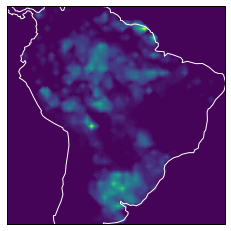

In [11]:
import cartopy.crs as ccrs
import matplotlib.pyplot as plt
import cartopy
#sample, ch, time, lat, lon
sst = train_data.y[0, 0, 0, :, :]
lats = dataset.variables['lat'][:]
lons = dataset.variables['lon'][:]

ax = plt.axes(projection=ccrs.PlateCarree())

plt.contourf(lons, lats, sst, 60,
             transform=ccrs.PlateCarree())
ax.coastlines(color='white')

plt.show()

In [12]:
class Mish(torch.nn.Module):
    def __init__(self):
        super().__init__()

    def forward(self, x):
        #inlining this saves 1 second per epoch (V100 GPU) vs having a temp x and then returning x(!)
        return x *( torch.tanh(F.softplus(x)))

In [13]:
class CustomConv2d(torch.nn.Conv2d):
    def __init__(self, in_channels, out_channels, kernel_size, stride=1,
                 padding=0, dilation=1,
                 bias=False, padding_mode='zeros', weight=None):
        super().__init__(in_channels, out_channels, kernel_size, stride=stride,
                 padding=padding, dilation=dilation,
                 bias=bias, padding_mode=padding_mode)
        
        self.padding = [kernel_size // 2, kernel_size // 2]
        if (weight is not None):
            self.weight = Parameter(weight.permute(1,0,2,3))
        
    def forward(self,input):
        return F.conv2d(input, self.weight, self.bias, self.stride,
                        self.padding, self.dilation)

In [14]:
class EncoderCNN(torch.nn.Module):
    def __init__(self, layer_size, kernel_size, initial_out_channels, initial_in_channels, input_size, hidden_size
                 ,device):
        super(EncoderCNN, self).__init__()
        self.conv_layers = torch.nn.ModuleList()
        self.mish_layers = torch.nn.ModuleList()
        self.bn_layers = torch.nn.ModuleList()
        self.dropout_layers = torch.nn.ModuleList()
        
        in_channels = initial_in_channels
        out_channels = initial_out_channels
        for i in range(layer_size):
            if (i == layer_size-1):
                out_channels = 1
            self.conv_layers.append(CustomConv2d(in_channels = in_channels, out_channels = out_channels,
                                                kernel_size = kernel_size))
            self.mish_layers.append(Mish())
            self.bn_layers.append(torch.nn.BatchNorm2d(out_channels))
            self.dropout_layers.append(torch.nn.Dropout(dropout_rate))
            in_channels = out_channels
        self.recurrent = MogrifierLSTMCell(input_size, hidden_size, mogrify_rounds)
            
            
            
    def forward(self, x, states, dimens):
        batch, channel, time, lat, lon = dimens
        x = x.view(batch*time, channel, lat, lon)
        for conv, bn, mish, dropout in zip(self.conv_layers, self.bn_layers, self.mish_layers, self.dropout_layers):
            x = conv(x)
            x = bn(x)
            x = mish(x)
            x = dropout(x)
        x = x.view(batch, time, -1)
        h = states[0]
        c = states[1]
        for i in range(time):
            h,c = self.recurrent(x[:,i,:],(h,c))
        return (h, c)

In [15]:
class DecoderCNN(torch.nn.Module):
    def __init__(self, layer_size, kernel_size, initial_out_channels, initial_in_channels, encoder_weights, input_size
                 ,prediction_window, device):
        super(DecoderCNN, self).__init__()
        self.device = device
        self.prediction_window = prediction_window
        self.conv_layers = torch.nn.ModuleList()
        self.mish_layers = torch.nn.ModuleList()
        self.bn_layers = torch.nn.ModuleList()
        self.dropout_layers = torch.nn.ModuleList()
        
        in_channels = initial_in_channels
        out_channels = initial_out_channels
        
        self.recurrent = MogrifierLSTMCell(input_size, hidden_size, mogrify_rounds)
        
        for i in range(layer_size):
            if (i == layer_size-1):
                out_channels = 1
            self.conv_layers.append(CustomConv2d(in_channels = in_channels, out_channels = out_channels,
                                                kernel_size = kernel_size, weight=encoder_weights[i]))
            self.mish_layers.append(Mish())
            self.bn_layers.append(torch.nn.BatchNorm2d(out_channels))
            self.dropout_layers.append(torch.nn.Dropout(dropout_rate))

            in_channels = out_channels
            
    def forward(self,states, dimens):
        batch, channel, time, lat, lon = dimens
        outputs = torch.zeros(batch, self.prediction_window, lat*lon, device=self.device)
        h = states[0]
        c = states[1]
        for i in range(self.prediction_window):
            h,c = self.recurrent(h,(h,c))
            outputs[:,i,:] = h
        x = outputs.contiguous().view(batch*self.prediction_window, channel, lat, lon)
        for conv, bn, mish, dropout in zip(self.conv_layers, self.bn_layers, self.mish_layers, self.dropout_layers):
            x = conv(x)
            x = bn(x)
            x = mish(x)
            x = dropout(x)
        return x.view(batch, self.prediction_window, channel, lat, lon)

In [16]:
class STModel(torch.nn.Module):
    def __init__(self, encoder_layer_size, decoder_layer_size,
                 kernel_size, out_channels, in_channels, input_width, input_height, recurrent_hidden, 
                mogrify_rounds, prediction_window, device):
        super(STModel, self).__init__()
        self.device = device
        self.prediction_window = prediction_window
        self.encoder = EncoderCNN(layer_size = encoder_layer_size, kernel_size = kernel_size,
                                initial_out_channels = out_channels,
                                initial_in_channels = in_channels, input_size=input_width*input_height,
                                 hidden_size = hidden_size, device=device)
        encoder_weights = [layer.weight for layer in self.encoder.conv_layers][::-1]
        self.decoder = DecoderCNN(layer_size = decoder_layer_size, kernel_size = kernel_size,
                                initial_out_channels = out_channels,
                                initial_in_channels = in_channels, encoder_weights = encoder_weights, 
                                input_size=input_width*input_height, prediction_window = prediction_window,
                                device=device)
        
        
    def forward(self, x, states):
        dimens = x.size()
        (h_t, c_t) = self.encoder(x, states, dimens)
        x = self.decoder((h_t,c_t), dimens)
        return x
        

In [17]:
class RMSELoss(torch.nn.Module):
    def __init__(self, eps=1e-6):
        super().__init__()
        self.mse = torch.nn.MSELoss()
        self.eps = eps
        
    def forward(self,yhat,y):
        loss = torch.sqrt(self.mse(yhat,y) + self.eps)
        return loss


In [18]:
model = STModel(encoder_layer_size = param['encoder_layer_size'], decoder_layer_size = param['decoder_layer_size']
                ,kernel_size = param['kernel_size'], out_channels = param['filter_size'],
                in_channels = train_data.x.shape[1], input_width = train_data.x.shape[3],
                input_height = train_data.x.shape[4], recurrent_hidden = hidden_size,
                mogrify_rounds = mogrify_rounds, prediction_window = prediction_window, device = device).to(device)
criterion = RMSELoss()
#optimizer_params = {'lr': 0.001}
#optimizer = torch.optim.Adam(net.parameters(), **optimizer_params)
opt_params = {'lr': 0.001, 
              'beta3': 0.999}
optimizer = adamod.AdaMod(model.parameters(), **opt_params)

In [19]:
class Evaluator:
    def __init__(self, model, loss, data_loader, device):
        self.model = model
        self.loss = loss
        self.data_loader = data_loader
        self.device = device
        
    def evaluate(self):
        with torch.no_grad():
            eval_loss = 0.0
            self.model.eval()
            for i, (x, y) in enumerate(self.data_loader):
                x,y = x.to(self.device), y.to(self.device)
                states = init_hidden(x.size()[0], x.size()[3]*x.size()[4])
                output, _ = self.model(x, states)
                loss = self.loss(output, y)
                eval_loss += loss.detach().item()
            avg_loss = eval_loss/len(self.data_loader)
        return avg_loss

In [20]:
class TrainingStop:
    def __init__(self, threshold):
        self.min_loss = sys.float_info.max
        self.count = 0
        self.threshold = threshold
        
    def check_stop_condition(self, curr_loss):
        if (curr_loss < self.min_loss):
            self.min_loss = curr_loss
            self.count = 0
            return False
        else:
            self.count += 1
            if (self.count >= self.threshold):
                return True
            return False

In [21]:
def init_hidden(batch_size, hidden_size):
    h = torch.zeros(batch_size,hidden_size, device=device)
    return (h,h)

#Might not be required, this is typically for BPTT to not backprop through the whole sequence between batches.
#Causes out of memory without this.
def repackage_hidden(states):
    if isinstance(states, torch.Tensor):
        return states.detach()
    else:
        return tuple(repackage_hidden(v) for v in states)

In [ ]:
train_losses, val_losses = [], []
evaluator = Evaluator(model, criterion, val_loader, device)
training_stopper = TrainingStop(3)
for epoch in range(1,100):
    train_loss = model.train()
    epoch_train_loss = 0.0
    for i, (x, y) in enumerate(train_loader):
        x,y = x.to(device), y.to(device)
        optimizer.zero_grad()
        states = init_hidden(x.size()[0], x.size()[3]*x.size()[4])
        output = model(x, states)
        loss = criterion(output, y)
        loss.backward()
        optimizer.step()
        epoch_train_loss += loss.detach().item()
    print(epoch_train_loss)
    avg_epoch_loss = epoch_train_loss/len(train_loader)
    train_losses.append(avg_epoch_loss)
    print('Train - Epoch %d, Batch: %d, Epoch Loss: %f' % (epoch, i, avg_epoch_loss))
    
    avg_loss = evaluator.evaluate()
    val_losses.append(avg_loss)
    print('Val Avg. Loss: %f' % (avg_loss))
    if (torch.cuda.is_available()):
                torch.cuda.empty_cache()
    if (training_stopper.check_stop_condition(avg_loss)):
        break

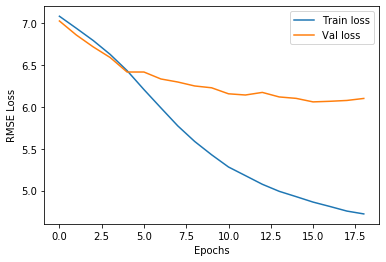

In [23]:
epochs = np.arange(1,len(train_losses))
plt.plot(train_losses)
plt.plot(val_losses)
plt.legend(['Train loss', 'Val loss'], loc='upper right')
plt.xlabel("Epochs")
plt.ylabel("RMSE Loss")
plt.show()

In [24]:
evaluator = Evaluator(model, criterion, test_loader, device)
test_loss = evaluator.evaluate()
loss_type = type(criterion).__name__
print(f'STTSModel {loss_type}: {test_loss:.4f}')

STTSModel RMSELoss: 6.0762
